Notebook showing usage of the data detective package.

In [1]:
# To import detective from relative folder
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import detective.core as detective
import detective.helpers as helpers
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # Suppress chained_assignment warning, default='warn'
import seaborn as sns
from sqlalchemy import text
import matplotlib.pyplot as plt
%matplotlib inline

To load from a local db, we just need the path

In [2]:
db_path = 'Users/robincole/Documents/Home-assistant_database/home-assistant_v2.db'
DB_URL = 'sqlite:////' + db_path

Alternatively, to load from a cloud database we load from a json file containing the url as the url contains our credentials and we want to lkeep these a secret. To learn how the Google CLoud SQL recorder can be setup checkout https://github.com/robmarkcole/HASS-Google-Cloud-SQL

In [3]:
# For cloud database with secret credentials, load from json. Time to load vaires, up to 3 mins.
#filename = '/Users/robincole/Desktop/hass_db_url.json'
#DB_URL = helpers.load_url(filename)

## Load the db data

We use the DataParser class to load data from the database. This class performs the SQL queries and parses the returned data. The class holds the master pandas dataframe master_df.

In [4]:
%%time
db = detective.HassDatabase(DB_URL) # To init without fetching entities fetch_entities=False

Successfully connected to sqlite:////Users/robincole/Documents/Home-assistant_database/home-assistant_v2.db
There are 261 entities with data
CPU times: user 527 ms, sys: 2.52 s, total: 3.05 s
Wall time: 11.8 s


In [5]:
db.domains

['sensor',
 'remote',
 'camera',
 'zone',
 'group',
 'light',
 'updater',
 'binary_sensor',
 'switch',
 'persistent_notification',
 'alarm_control_panel',
 'device_tracker',
 'media_player',
 'sun',
 'script',
 'automation',
 'input_select']

In [6]:
db.entities['binary_sensor']

['binary_sensor.motion_at_home',
 'binary_sensor.living_room_motion_sensor',
 'binary_sensor.in_bed_bayesian',
 'binary_sensor.hall_motion_sensor',
 'binary_sensor.bedroom_motion_sensor',
 'binary_sensor.blink_armed_status',
 'binary_sensor.blink_blink_camera_percy_motion_enabled',
 'binary_sensor.workday_sensor',
 'binary_sensor.living_room_nest_protect_online',
 'binary_sensor.bayesianbinary']

In [7]:
db.entities['sensor'][15:20]

['sensor.living_room_temperature',
 'sensor.hall_light_sensor',
 'sensor.home_to_waterloo',
 'sensor.work_to_home',
 'sensor.living_room_light_sensor']

## Simple query

Lets query a single sensor and demonstrate the data processing steps implemented by the library

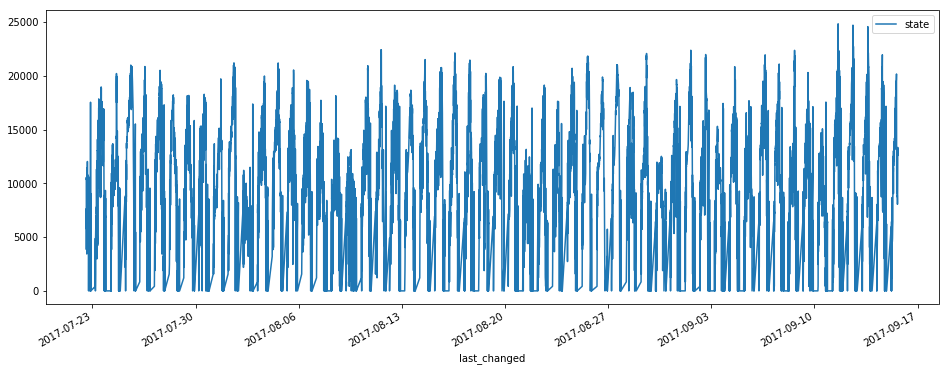

In [8]:
query = text(
    """
    SELECT state, last_changed
    FROM states
    WHERE entity_id in ('sensor.hall_light_sensor') 
    AND NOT state='unknown'
    """
    )
response = db.perform_query(query)
df = pd.DataFrame(response.fetchall()) # Convert to dataframe
df.columns = ['state', 'last_changed'] # Set the columns
df = df.set_index('last_changed') # Set the index on datetime
df.index = pd.to_datetime(df.index) # Convert string to datetime
df = df.mask(df.eq('None')).dropna().astype(float) #  Convert state strings to floats for plotting
df.plot(figsize=(16, 6));

## Helper to query by list
Use `fetch_data_by_list` to query a list of numerical entities, must be from same domain and a minimum of 2 entities must be in the list. Returns a pandas dataframe.

In [9]:
db.fetch_data_by_list(db.entities['sensor'][15])

Must pass more than 1 entity.


In [10]:
%%time
df = db.fetch_data_by_list(db.entities['sensor'][15:17])

CPU times: user 196 ms, sys: 374 ms, total: 569 ms
Wall time: 1.71 s


In [11]:
df.head()

entity,sensor.hall_light_sensor,sensor.living_room_temperature
last_changed,,
2017-07-22 14:22:28.950795+00:00,6858.0,20.68
2017-07-22 14:22:29.053893+00:00,6858.0,20.68
2017-07-22 14:23:10.703517+00:00,6858.0,20.96
2017-07-22 14:26:59.745763+00:00,6334.0,20.96
2017-07-22 14:31:59.744730+00:00,5864.0,20.96


In [12]:
df['sensor.hall_light_sensor'].describe()

count    23213.000000
mean      9263.393874
std       5984.677651
min          0.000000
25%       4895.000000
50%      10291.000000
75%      13142.000000
max      24845.000000
Name: sensor.hall_light_sensor, dtype: float64

## Query all data
Data-detective takes care of parsing data from the database, intelligently sorting out numerical and categorical data and formatting them correctly. Use `fetch_all_data` to import all your db data into a pandas dataframe in memory -> this approach means it can take a while to load the data into memory, but subsequent processing and handling are much faster/easier.

In [13]:
pd.to_datetime('13000101', format='%Y%m%d', errors='ignore', utc=True)

datetime.datetime(1300, 1, 1, 0, 0)

In [14]:
%%time
db.fetch_all_data()

Querying the database, this could take a while
master_df created successfully.
CPU times: user 12.5 s, sys: 15.4 s, total: 28 s
Wall time: 1min 7s


The `NumericalSensors` class is for parsing the numerical data. Lets create a dataframe for the numerical sensor data

In [15]:
sensors_num_df = detective.NumericalSensors(db.master_df)

We can access the list of sensor entities using the list_sensors attribute

In [16]:
sensors_num_df.entities[0:10]

['sensor.next_train_to_wat',
 'sensor.next_bus_to_new_malden',
 'sensor.darksky_sensor_temperature',
 'sensor.darksky_sensor_precip_probability',
 'sensor.iphone_battery_level',
 'sensor.robins_iphone_battery_level',
 'sensor.blink_blink_camera_percy_temperature',
 'sensor.blink_blink_camera_percy_notifications',
 'sensor.next_train_in',
 'sensor.home_to_waterloo']

Now lets look at the dataframe

In [17]:
sensors_num_df.data.head()

entity,sensor.average_indoor_temp,sensor.bedroom_light_sensor,sensor.bedroom_temperature,sensor.blink_blink_camera_percy_notifications,sensor.blink_blink_camera_percy_temperature,sensor.bme680air_qual,sensor.bme680humidity,sensor.bme680pressure,sensor.bme680temperature,sensor.breaches_fredallcardgmailcom,...,sensor.next_train_to_wat,sensor.next_train_to_wim,sensor.remote_living_room_button,sensor.robins_iphone_battery_level,sensor.speedtest_download,sensor.volume_used_volume_1,sensor.wipy_humidity,sensor.wipy_memory,sensor.wipy_temperature,sensor.work_to_home
last_changed,,,,,,,,,,,,,,,,,,,,,
2017-10-28 06:48:00.143377,20.2,15621.0,18.89,1.0,21.0,98.51,43.58,1033.93,21.07,0.0,...,1125.0,87.0,1002.0,94.0,36.37,20.7,14.0,38112.0,32.0,25.0
2017-10-28 06:48:01.060922,20.2,15621.0,18.89,1.0,21.0,98.51,43.50,1033.93,21.07,0.0,...,1125.0,87.0,1002.0,94.0,36.37,20.7,14.0,38112.0,32.0,25.0
2017-10-28 06:48:01.069416,20.2,15621.0,18.89,1.0,21.0,98.51,43.50,1033.93,21.06,0.0,...,1125.0,87.0,1002.0,94.0,36.37,20.7,14.0,38112.0,32.0,25.0
2017-10-28 06:48:01.076784,20.2,15621.0,18.89,1.0,21.0,98.51,43.50,1033.95,21.06,0.0,...,1125.0,87.0,1002.0,94.0,36.37,20.7,14.0,38112.0,32.0,25.0
2017-10-28 06:48:01.079950,20.2,15621.0,18.89,1.0,21.0,98.54,43.50,1033.95,21.06,0.0,...,1125.0,87.0,1002.0,94.0,36.37,20.7,14.0,38112.0,32.0,25.0


Lets now check for correlations in the data using the all_corrs() method

In [18]:
corrs = sensors_num_df.correlations()

In [19]:
corrs[(corrs['value'] > 0.8) | (corrs['value'] < -0.8)]

,value
sensor.next_train_in-sensor.next_train_to_wim,0.999961
sensor.iphone_battery_level-sensor.robins_iphone_battery_level,0.923446
sensor.bme680air_qual-sensor.bme680pressure,0.862630
sensor.mean_temperature-sensor.bedroom_temperature,0.814340
sensor.living_room_temperature-sensor.bme680temperature,0.801827
sensor.bme680pressure-sensor.darksky_sensor_temperature,-0.810146
sensor.bme680humidity-sensor.bme680pressure,-0.862619
sensor.memory_usage_real-sensor.volume_used_volume_1,-0.902779
sensor.bme680humidity-sensor.bme680air_qual,-0.999989


Unsurprisingly the mean temperature is strongly correlated with all of the temperature sensors. 

Interestingly my iphone battery level is somewhat inversely correlated with the travel time from home to waterloo, which gets longer late at night when my battery level is more likely to be low. 

#### Plot sensor data
Convenience to plot a sensor data.
Pass a single entity to plot:

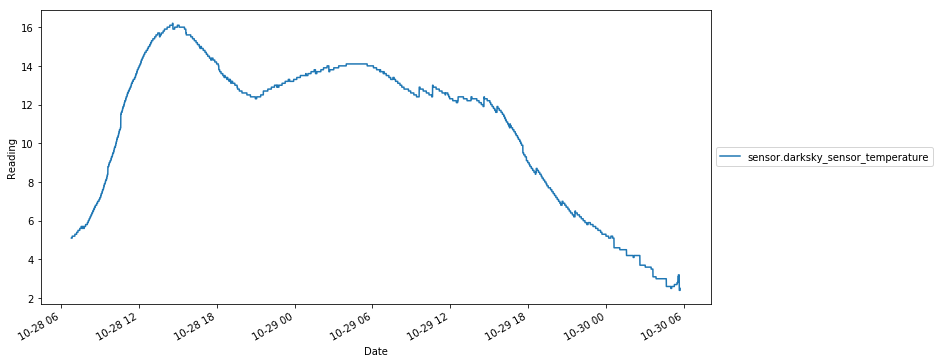

In [20]:
sensors_num_df.plot('sensor.darksky_sensor_temperature')

We can pass a list of entities to plot:

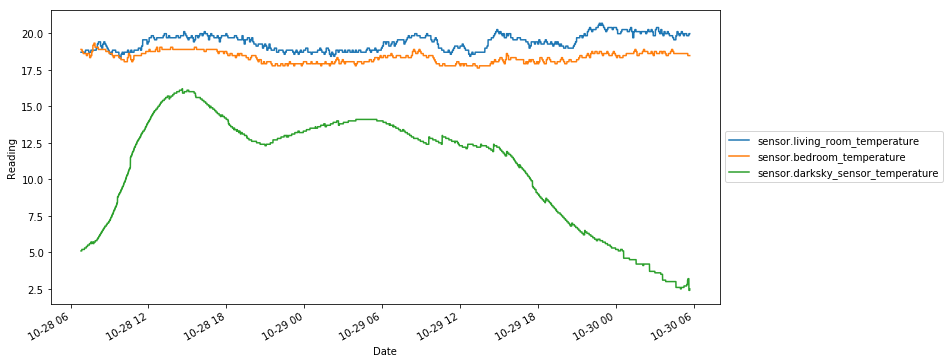

In [21]:
to_plot = ['sensor.living_room_temperature',
           'sensor.bedroom_temperature',
           'sensor.darksky_sensor_temperature']

sensors_num_df.plot(to_plot)

Even mix up lists and single entites

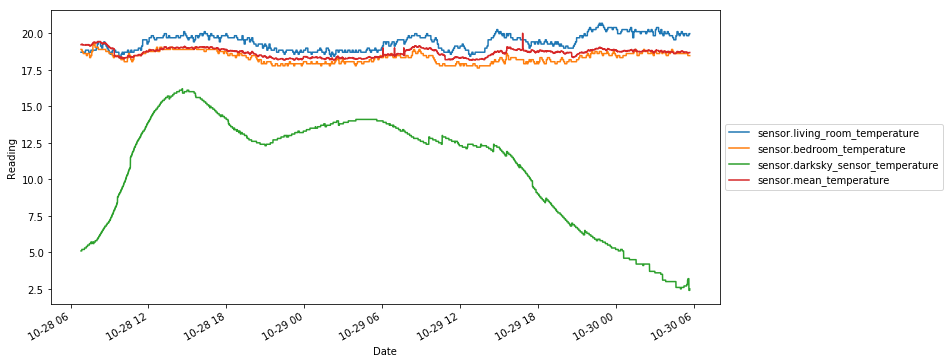

In [22]:
sensors_num_df.plot(to_plot, 'sensor.mean_temperature')

#### Pairplot
A seaborn pair plot to show correlations.

CPU times: user 3.77 s, sys: 121 ms, total: 3.89 s
Wall time: 3.93 s


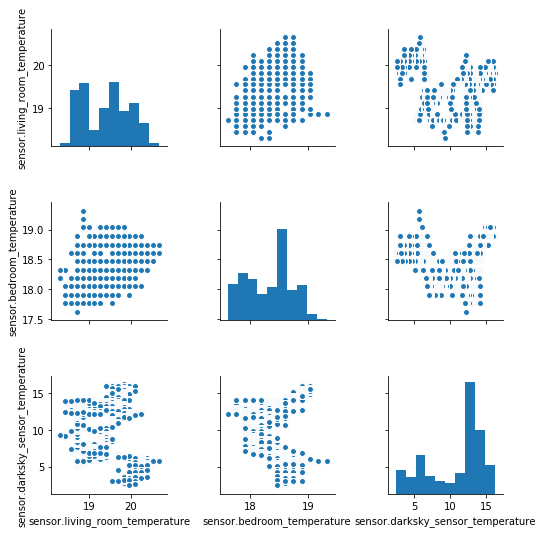

In [23]:
%%time
sns.pairplot(sensors_num_df.data[to_plot]);

## Binary sensors
The `BinarySensors` class is for binary sensor data with on/off states.

In [24]:
sensors_binary_df = detective.BinarySensors(db.master_df)

In [25]:
sensors_binary_df.entities

['binary_sensor.workday_sensor',
 'binary_sensor.blink_blink_camera_percy_motion_enabled',
 'binary_sensor.living_room_nest_protect_online',
 'binary_sensor.blink_armed_status',
 'binary_sensor.hall_motion_sensor',
 'binary_sensor.bedroom_motion_sensor',
 'binary_sensor.living_room_motion_sensor',
 'binary_sensor.motion_at_home',
 'binary_sensor.bayesianbinary',
 'binary_sensor.in_bed_bayesian']

Currently we can plot a single binary sensor with the plot() method

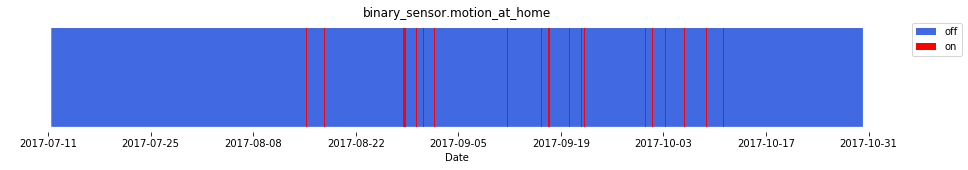

In [26]:
sensors_binary_df.plot('binary_sensor.motion_at_home')

## Day of week analysis

Lets analyse the **motion_at_home**, create some features for day of week and time category, then analyse motion by these features.

In [27]:
motion_df = sensors_binary_df.data[['binary_sensor.motion_at_home']] # Must pass a list to return correctly indexed df

In [28]:
motion_df['weekday'] = motion_df.index.weekday_name

In [29]:
motion_df['is_weekday'] = motion_df.index.map(lambda x: helpers.is_weekday(x))

In [30]:
motion_df = motion_df[motion_df['binary_sensor.motion_at_home'] == True] # Keep only true detection events

In [31]:
motion_df['time_category'] = motion_df.index.map(lambda x: helpers.time_category(x))

In [32]:
motion_df.head()

entity,binary_sensor.motion_at_home,weekday,is_weekday,time_category
last_changed,,,,
2017-08-07 20:08:17.810800,True,Monday,True,evening
2017-08-07 20:08:26.921077,True,Monday,True,evening
2017-08-07 20:10:20.017217,True,Monday,True,evening
2017-08-07 20:11:31.024414,True,Monday,True,evening
2017-08-07 20:12:02.027471,True,Monday,True,evening


In [33]:
motion_df['binary_sensor.motion_at_home'].groupby(motion_df['is_weekday']).describe()['count']

is_weekday
False     4452
True     10862
Name: count, dtype: object

In [34]:
motion_df_gb = motion_df['binary_sensor.motion_at_home'].groupby([motion_df['weekday'], motion_df['time_category']]).sum().unstack()
motion_df_gb.fillna(value=0, inplace=True)   # Replace NaN with 0
motion_df_gb = motion_df_gb.astype('int')              # Ints rather than floats
motion_df_gb = motion_df_gb.T
motion_df_gb

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
time_category,,,,,,,
daytime,1000,690,962,631,844,880,800
evening,394,599,239,496,453,532,545
morning,839,688,1047,833,664,655,619
night,92,93,131,113,163,149,163


Text(0.5,1,'Activity at home by day and time category')

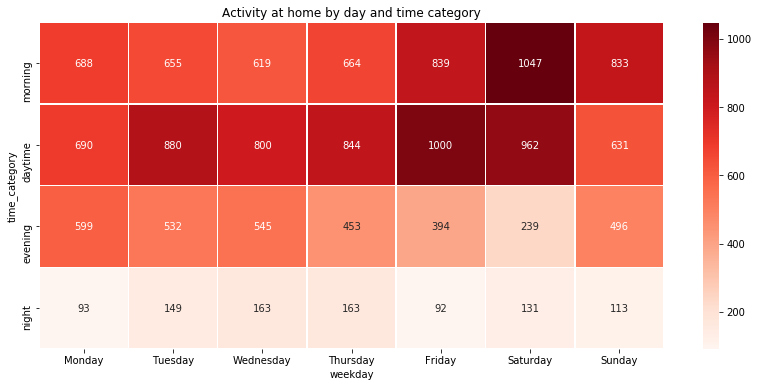

In [35]:
fig, ax = plt.subplots(figsize=(14, 6))
days_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times_list = ['morning', 'daytime', 'evening', 'night']
ax = sns.heatmap(motion_df_gb[days_list].loc[times_list], annot=True, linewidths=.5, fmt="d", ax=ax, cmap='Reds');
ax.set_title('Activity at home by day and time category')
#fig.savefig('heatmap.jpg')